In [1]:
import pandas as pd
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
data = pd.read_csv("C:/Users/zdunkerton/Documents/GitHubData/Stocks/aapl.us.txt")
data = data.drop('OpenInt', 1)

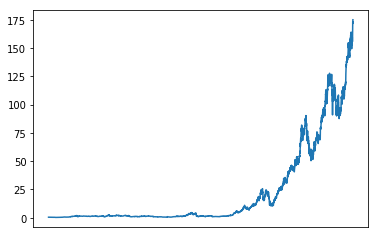

In [16]:
plt.plot(data["Date"], data["Open"])
plt.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off') 
plt.show()

In [126]:
tf.reset_default_graph()
n_steps = 50
n_inputs = 1
n_neurons = 100
n_outputs = 1


learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units = n_neurons, activation=tf.nn.relu),
    output_size = n_outputs)

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

loss = tf.reduce_mean(tf.square(outputs-y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
    
init = tf.global_variables_initializer()
mse_summary = tf.summary.scalar('Loss', loss)
logdir = "./tf_logs/"
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [127]:
def next_batch(batch_size, n_steps):
    x = []
    y = []
    count = 0
    while count<batch_size:
        rnd = np.random.randint(0,len(data)-n_steps,n_steps)
        values = []
        for num in rnd:
            values.append(data.iloc[num, 1])
        x.append(rnd)
        y.append(np.array(values))
        count+=1
    return np.array(x),np.array(y)

In [147]:
batch_size=50
n_steps = 50
n_inputs = 1
n_iterations = 1500
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        i = iteration*batch_size
        j = (iteration+1)*batch_size
        X_batch, y_batch = next_batch(batch_size, n_steps)
        X_batch, y_batch = X_batch.reshape((-1, n_steps, n_inputs)), y_batch.reshape((-1, n_steps, n_inputs))
        sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        if iteration%100 == 0:
            mse = loss.eval(feed_dict={X:X_batch, y:y_batch})
            print(iteration, "\tMSE:", mse)
        if iteration%10 == 0:
            summary_str = mse_summary.eval(feed_dict={X:X_batch, y:y_batch})
            step = iteration*batch_size 
            file_writer.add_summary(summary_str, step)
    file_writer.close()
    X_new = np.arange(len(data)-n_steps,len(data),dtype = 'int32')
    X_new = X_new.reshape((-1, n_steps, n_inputs))
    y_new = sess.run(outputs, feed_dict={X:X_new})
    y_pred = np.mean(y_new)

0 	MSE: 55697.543
100 	MSE: 827.98157
200 	MSE: 563.2824
300 	MSE: 472.6262
400 	MSE: 424.23166
500 	MSE: 386.52744
600 	MSE: 372.14218
700 	MSE: 268.54956
800 	MSE: 260.0769
900 	MSE: 255.03172
1000 	MSE: 242.0038
1100 	MSE: 263.82913
1200 	MSE: 219.42834
1300 	MSE: 227.4292
1400 	MSE: 197.895


50
1


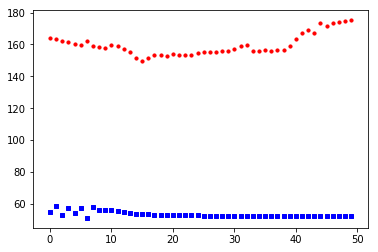

In [162]:
new_data = list(data.iloc[len(data)-n_steps:len(data),1])
rng = range(n_steps)
fig = plt.figure()
ax1 = fig.add_subplot(111)
print(len(list(new_data)))
print(len(list(y_new)))
ax1.scatter(rng,list(y_new), s=10, c='b', marker="s", label='predicted')
ax1.scatter(rng,new_data, s=10, c='r', marker="o", label='actual')
plt.show()

To run use tensorboard, run "python  -m tensorboard.main --logdir tf_logs/